In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
import mglearn
from sklearnex  import  patch_sklearn 
patch_sklearn ()

data_dir = "../Dataset"


def get_data(data_dir: str) -> pd.DataFrame:
    data = pd.DataFrame()
    #data['Trafico'] = 2
    for path in os.listdir(data_dir):    #para cada archivo de la carpeta        
        dir_content = os.path.join(data_dir, path)   #unir cada nombre del archivo al directorio
        if os.path.isfile(dir_content):   #compruebo si es archivo (nombre de ruta absoluto)
            directory = pd.read_csv(dir_content)

        data = pd.concat([data, directory], ignore_index = True)                
    return data


dataset = get_data(data_dir)
print(dataset.shape)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


(343889, 84)


Text(0.5, 1.0, 'Correlación positiva superior al 0.95')

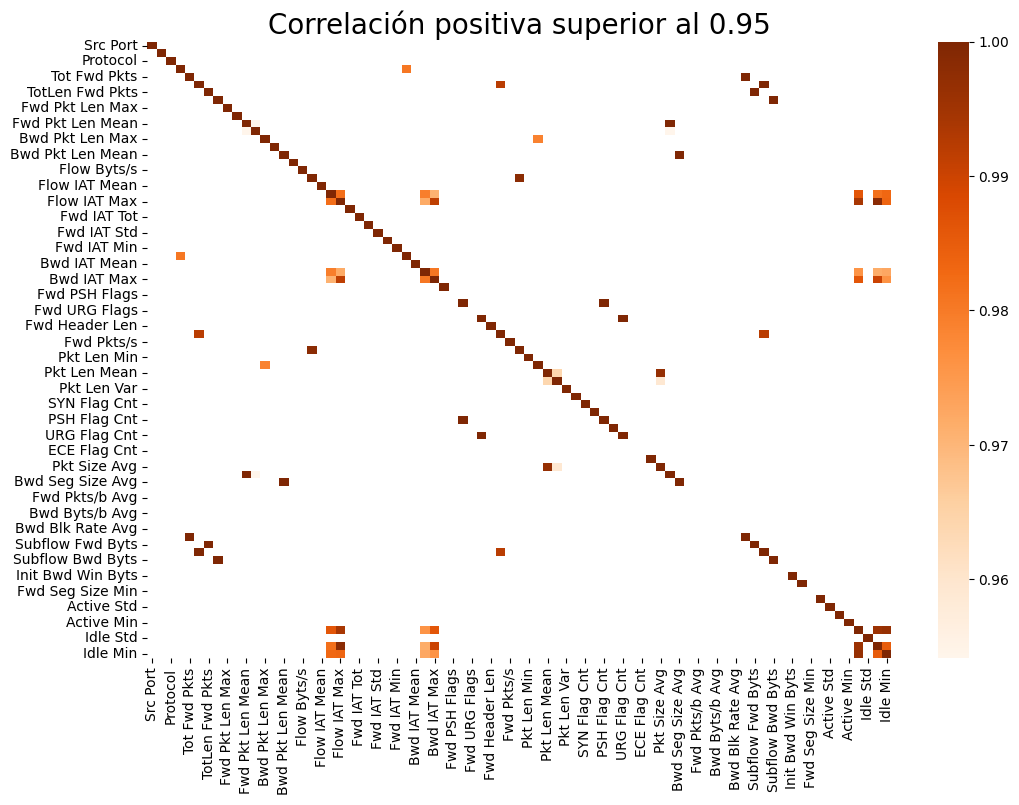

In [2]:
import seaborn as sns

corr = dataset.corr()
kot = corr[corr>=0.95]
#kot.to_csv('correlacion.csv')
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Oranges").set_title('Correlación positiva superior al 0.95', fontsize=20)

Text(0.5, 1.0, 'Correlación negativa inferior al -0.2')

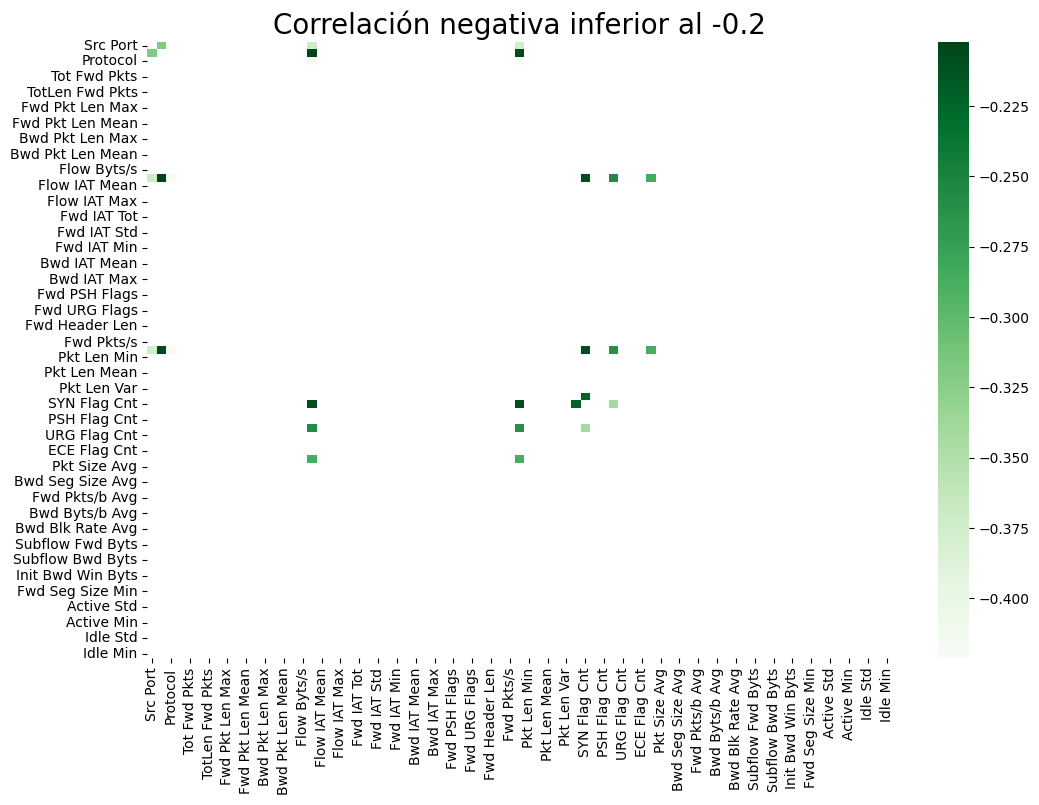

In [3]:
corr = dataset.corr()
kot = corr[corr<=-0.2]
kot.to_csv('correlacion_negativa.csv')
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens").set_title('Correlación negativa inferior al -0.2', fontsize=20)

In [37]:
dataset = dataset.drop(['Flow ID', 'Fwd PSH Flags', 'Fwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Init Fwd Win Byts', 'Fwd Seg Size Min', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Pkt Size Avg', 'PSH Flag Cnt', 'URG Flag Cnt', 'Label'], axis=1)
dataset = dataset.drop([170893, 170896, 170897, 170898, 170899, 170902, 170903, 170906], axis=0)


In [38]:
dataset['Src-192.168.3.'] = np.where(dataset['Src IP'].str.startswith('192.168.3.'), 1,0)
dataset['Src-192.168.20.'] = np.where(dataset['Src IP'].str.startswith('192.168.20.'), 1,0)
dataset['Src-192.168.8.'] = np.where(dataset['Src IP'].str.startswith('192.168.8.'), 1,0)
dataset['Src-172.17.0.'] = np.where(dataset['Src IP'].str.startswith('172.17.0.'), 1,0)
dataset['Src-200.175.2.0'] = np.where(dataset['Src IP'].str.startswith('200.175.2.0.'), 1,0)

dataset['Dst-192.168.3.'] = np.where(dataset['Dst IP'].str.startswith('192.168.3.'), 1,0)
dataset['Dst-192.168.20.'] = np.where(dataset['Dst IP'].str.startswith('192.168.20.'), 1,0)
dataset['Dst-192.168.8.'] = np.where(dataset['Dst IP'].str.startswith('192.168.8.'), 1,0)
dataset['Dst-172.17.0.'] = np.where(dataset['Dst IP'].str.startswith('172.17.0.'), 1,0)
dataset['Dst-200.175.2.0'] = np.where(dataset['Dst IP'].str.startswith('200.175.2.0.'), 1,0)

dataset['Src_Port 0-1023'] = np.where(dataset['Src Port'] < 1024, 1,0)
dataset['Src_Port 1024-49151'] = np.where((dataset['Src Port'] >= 1024) & (dataset['Src Port'] < 49152), 1,0)
#En el caso que los dos valores anteriores sean 0, el valor del puerto se encuentra en el rango 49152-65535

dataset['Dst_Port_0-1023'] = np.where(dataset['Dst Port'] < 1024, 1,0)
dataset['Dst_Port_1024-49151'] = np.where((dataset['Dst Port'] >= 1024) & (dataset['Dst Port'] < 49152), 1,0)
#En el caso que los dos valores anteriores sean 0, el valor del puerto se encuentra en el rango 49152-65535

dataset = pd.get_dummies(dataset, prefix={'Protocol': 'Protocol'}, columns=['Protocol'],drop_first=True)

datetime = pd.to_datetime(dataset['Timestamp'], dayfirst = True)
horas = datetime.dt.hour
dataset['hora_sin'] = np.sin(horas*(2.*np.pi/24))
dataset['hora_cos'] = np.cos(horas*(2.*np.pi/24))

dataset['Weekend'] = pd.to_datetime(dataset['Timestamp'],dayfirst=True).dt.weekday
dataset['Weekend'] = (dataset['Weekend'] > 4).astype(int)


dataset = dataset.drop(['Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Timestamp'], axis=1)

Text(0.5, 1.0, 'Distribución de valores anómalos')

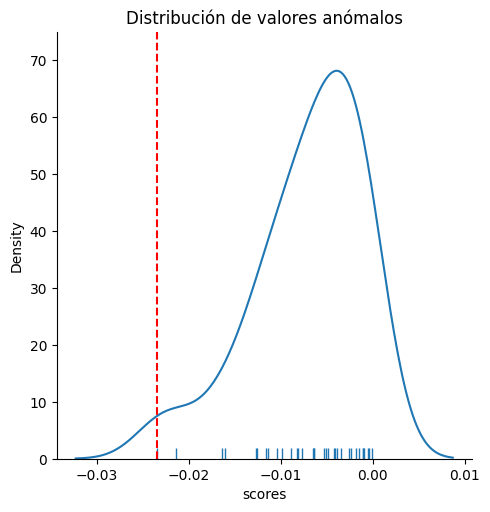

In [39]:
import seaborn as sns
from sklearn.ensemble import IsolationForest

dataset['scores'] = 0

random_state = np.random.RandomState(42)
iforest = IsolationForest(n_estimators=100, contamination= 0.0001, max_samples='auto', max_features=0.8, random_state= random_state)
iforest.fit(dataset.values)

dataset['scores'] = iforest.decision_function(dataset.values)
dataset['anomaly_scores'] = iforest.predict(dataset.values)
anomaly_scores = dataset[dataset['anomaly_scores'] == -1]

umbral = np.quantile(anomaly_scores['scores'], q = 0.0001)
sns.displot(data = anomaly_scores, x='scores', kind = 'kde', rug = True)
plt.axvline(umbral, c='red', linestyle='--', label='umbral')
plt.title('Distribución de valores anómalos')



<AxesSubplot:xlabel='anomaly_scores', ylabel='scores'>

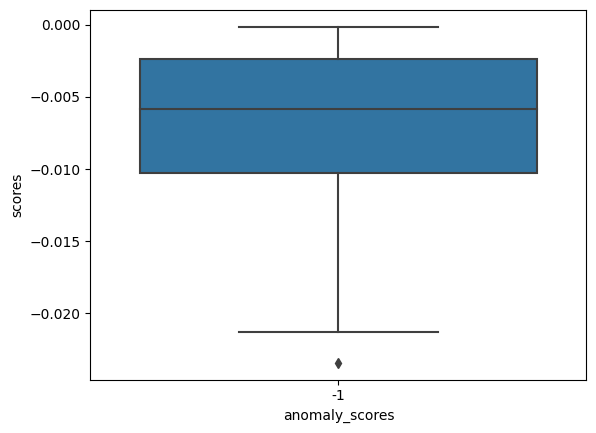

In [40]:
sns.boxplot(x = 'anomaly_scores', y='scores', data= anomaly_scores, palette= 'tab10')

In [41]:

dataset = dataset[dataset['scores']>=umbral]
dataset = dataset.drop(['scores', 'anomaly_scores'], axis=1)


(343881, 76)
(343880, 74)


In [22]:
dataset.to_csv('dataset_limpio.csv')

342770
1110
(343880, 74)


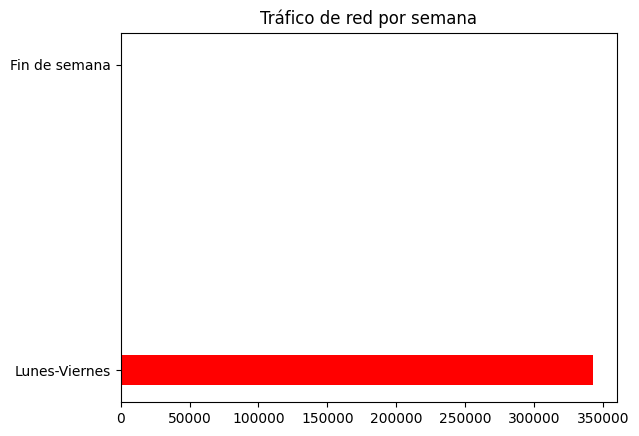

In [35]:
Finde = dataset['Weekend'][dataset['Weekend'] == 1].count()
Dia_Normal = dataset['Weekend'][dataset['Weekend'] == 0].count()

x = ['Lunes-Viernes', 'Fin de semana' ]
Trafico = [Dia_Normal, Finde]
print(Dia_Normal)
print(Finde)
print(dataset.shape)

plt.barh(x, Trafico, height = 0.1, color='red')
plt.title('Tráfico de red por semana')
plt.show()

(0.0, 2000.0)

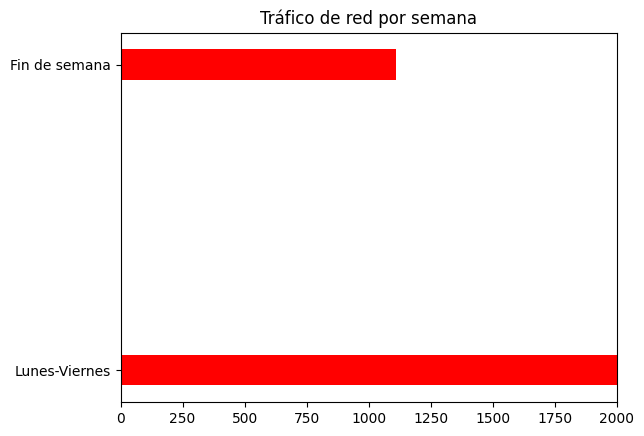

In [32]:
plt.barh(x, Trafico, height = 0.1, color='red')
plt.title('Tráfico de red por semana')
plt.xlim(0,2000)

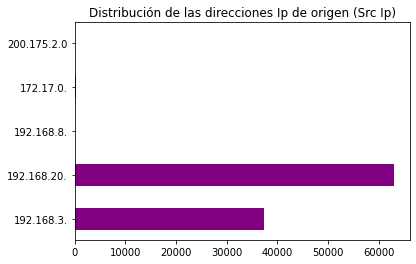

In [11]:
Ip_192_168_3 = dataset['Src-192.168.3.'][dataset['Src-192.168.3.'] == 1].count()
Ip_192_168_20 = dataset['Src-192.168.20.'][dataset['Src-192.168.20.'] == 1].count()
Ip_192_168_8 = dataset['Src-192.168.8.'][dataset['Src-192.168.8.'] == 1].count()
Ip_172_17_0 = dataset['Src-172.17.0.'][dataset['Src-172.17.0.'] == 1].count()
Ip_200_175_2_0 = dataset['Src-200.175.2.0'][dataset['Src-200.175.2.0'] == 1].count()

x = ['192.168.3.', '192.168.20.', '192.168.8.', '172.17.0.', '200.175.2.0' ]
Src_IPs = [Ip_192_168_3, Ip_192_168_20, Ip_192_168_8, Ip_172_17_0, Ip_200_175_2_0]

plt.barh(x, Src_IPs, height = 0.5, color='purple')
plt.title('Distribución de las direcciones Ip de origen (Src Ip)')
plt.show()

(0.0, 170.0)

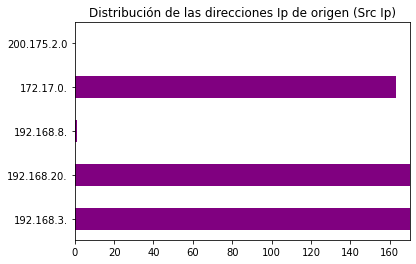

In [10]:
plt.barh(x, Src_IPs, height = 0.5, color='purple')
plt.title('Distribución de las direcciones Ip de origen (Src Ip)')
plt.xlim(0,170)

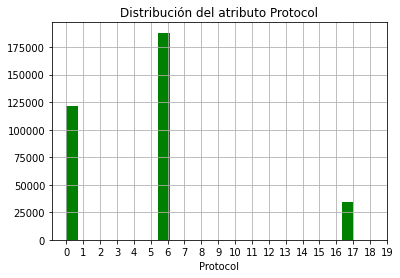

In [7]:
dataset = dataset[['Src Port', 'Dst Port', 'Protocol']]
dataset['Protocol'].hist(bins = 25, color= "green")
plt.title('Distribución del atributo Protocol')
plt.xlabel('Protocol')
plt.xticks(np.arange(20))
plt.show()

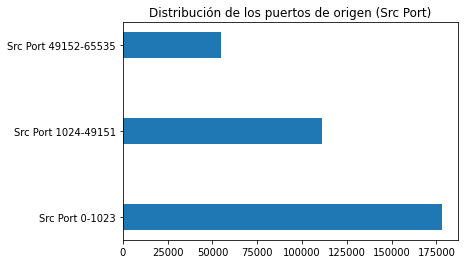

In [6]:
Port_0_1023 = dataset['Src Port 0-1023'][dataset['Src Port 0-1023'] == 1].count()
Port_1024_49151 = dataset['Src Port 1024-49151'][dataset['Src Port 1024-49151'] == 1].count()
Port_49152_65535 = dataset['Src Port 49152-65535'][dataset['Src Port 49152-65535'] == 1].count()
Puertos = [Port_0_1023, Port_1024_49151, Port_49152_65535]
x = ['Src Port 0-1023', 'Src Port 1024-49151', 'Src Port 49152-65535']
plt.barh(x, Puertos, height = 0.3)
plt.title('Distribución de los puertos de origen (Src Port)')
plt.show()

In [92]:
valores_ausentes = dataset.isna().sum().sort_values()
print(valores_ausentes)

Trafico             0
Fwd Seg Size Avg    0
Pkt Size Avg        0
Down/Up Ratio       0
ECE Flag Cnt        0
                   ..
Flow IAT Std        0
Flow IAT Mean       0
Flow Pkts/s         0
Fwd IAT Max         0
Label               0
Length: 86, dtype: int64
